## **Обучение моделей**

In [1]:
# импортируем необходимые библиотеки для работы с данными
import pandas as pd
import numpy as np
import pickle 

# импортируем необходимые библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns

# импортируем необходимые библиотеки для создания и обучения моделей
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch

### Загружаем обработанную таблицу и разбиваем на обучающий и валидационный набор

In [2]:
df = pd.read_csv('../data/df_after_cleaning.csv', sep = ',') #загрузка таблицы

In [3]:
df.info() #посмотрим информацию по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6800 non-null   int64  
 1   Date           6800 non-null   object 
 2   Month          6800 non-null   object 
 3   Weekday        6800 non-null   object 
 4   DateTime       6800 non-null   object 
 5   Hour           6800 non-null   int64  
 6   CO(GT)         6800 non-null   float64
 7   PT08.S1(CO)    6800 non-null   float64
 8   C6H6(GT)       6800 non-null   float64
 9   PT08.S2(NMHC)  6800 non-null   float64
 10  NOx(GT)        6800 non-null   float64
 11  PT08.S3(NOx)   6800 non-null   float64
 12  NO2(GT)        6800 non-null   float64
 13  PT08.S4(NO2)   6800 non-null   float64
 14  PT08.S5(O3)    6800 non-null   float64
 15  T              6800 non-null   float64
 16  RH             6800 non-null   float64
 17  AH             6800 non-null   float64
 18  Month_nu

In [4]:
y = df['CO(GT)'] #берём таргет
x = df.loc[:, ['Month_num', 'Weekday_num', 'Hour', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']] #оставляем столбцы без таргета
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #разбиваем на обучающую и валидационные выборки

### Нормализуем данные при помощи класса StandardScaler пакета sklearn. 

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) #находим параметры нормализации и на месте нормализуем обучающий набор
X_test = scaler.transform(X_test) # также валидационынй набор

In [19]:
with open('web-api\models\scaler.pkl', 'wb') as file: #сохраняем StandartScaler для использования его параметрах на данных для предсказания
    pickle.dump(scaler, file)

### Далее поочерёдно обучаем Линейную модель, Лассо, Случайный лес, Support Vector Regressor (SVR), К-ближайших соседей и полносвязанную нейронную сеть

In [16]:
lin_model = LinearRegression() #загружаем модель
lin_model.fit(X_train, y_train) #обучаем на данных
y_pred = lin_model.predict(X_test) #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Метрика R2: 0.9194408850611999
MAE: 0.23543254284690215


In [17]:
with open('models/linear_model.pkl', 'wb') as file: #сохраняем линейную модель
    pickle.dump(lin_model, file)

### Обучаем Lasso и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [18]:
lasso_model = Lasso() #загружаем модель
parameters = {'alpha': [0.1, 0.5, 1, 3, 5]} #гиперпараметы (всего 5 вариантов модели с  разными гиперпараметрами будет построено)
lasso = GridSearchCV(lasso_model, parameters)
lasso.fit(X_train, y_train) #обучаем на данных
y_pred = lasso.predict(X_test) #делаем предсказания
print('Лучшие гиперпараметры', lasso.best_params_)  #смотрим лучший вариант гиперпараметров
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'alpha': 0.1}
Метрика R2: 0.8995855098014857
MAE: 0.2642299409443292


In [19]:
with open('models/lasso_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(lasso, file)

### Обучаем Support Vector Regressor и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [12]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10, 12]}  #гиперпараметы (всего 8 вариантов модели с  разными гиперпараметрами будет построено)
svr_model = SVR() #загружаем модель
svr = GridSearchCV(svr_model, parameters)
svr.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', svr.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = svr.predict(X_test)#делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'C': 12, 'kernel': 'rbf'}
Метрика R2: 0.9458188874682436
MAE: 0.16925426995840126


In [ ]:
with open('models/svr_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(svr, file)

### Обучаем Случайный лес и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 3

In [22]:
forest_model = RandomForestRegressor(warm_start = True) #загружаем модель
parameters = {'n_estimators':(100, 150, 200), 
                'criterion':['squared_error', 'absolute_error'],
                'max_depth': [15, 20],
                'max_features': ['sqrt', 'log2']}  #гиперпараметы (всего 24 вариантов модели с  разными гиперпараметрами будет построено)


forest = GridSearchCV(forest_model, parameters, cv = 3)
forest.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', forest.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = forest.predict(X_test) #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Метрика R2: 0.9437061778622663
MAE: 0.19322033489646473


In [26]:
with open(r'models/forest_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(forest, file)

### Обучаем К ближайших соседей и подбираем лучшие гиперапараметры методом "поиска по сетке" с кросс-валидацией на k-folds = 5

In [24]:
#K-ближайших соседей
neigh_model = KNeighborsRegressor()
parameters = {'n_neighbors': (3, 5, 7, 9, 11), 
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree']} #гиперпараметы (всего 30 вариантов модели с  разными гиперпараметрами будет построено)


neigh = GridSearchCV(neigh_model, parameters)
neigh.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', neigh.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = neigh.predict(X_test)  #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
Метрика R2: 0.9355555625990593
MAE: 0.20553727282589399


In [25]:
with open(r'models/knn_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(neigh, file)

In [15]:
boosting_model = GradientBoostingRegressor()
parameters = {'loss': ['squared_error', 'huber'], 
                'learning_rate': [0.1, 0.05],
                'n_estimators': [100, 150, 200]} #гиперпараметы (всего 12 вариантов модели с  разными гиперпараметрами будет построено)

boosting = GridSearchCV(boosting_model, parameters)
boosting.fit(X_train, y_train) #обучаем на данных
print('Лучшие гиперпараметры', boosting.best_params_) #смотрим лучший вариант гиперпараметров
y_pred = boosting.predict(X_test)  #делаем предсказания
print('Метрика R2:', r2_score(y_test, y_pred)) #смотрим метрику r2
print('MAE:', mean_absolute_error(y_test, y_pred)) # смотрим размер ошибки MAE

Лучшие гиперпараметры {'learning_rate': 0.1, 'loss': 'squared_error', 'n_estimators': 200}
Метрика R2: 0.9415820372150157
MAE: 0.20725566742946644


In [16]:
with open(r'web-api\models\boosting_model.pkl', 'wb') as file: #сохраняем модель
    pickle.dump(boosting, file)

### Далее создаём полносвязанную нейронную сеть, состоящую из 4 линейных слоёв, функции активации ReLu, нормализации и Dropout с вероятность 0.2. Для этого используем пакет pytroch

In [31]:
#создаём класс для загрузки данных
class air_dataset(Dataset): #наследуем от родительского класса Dataset
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, ind): 
        features = torch.from_numpy(self.x[ind]).to(torch.float32)  #переводим столбец таблицы в формата тензора с числами float 32
        label = torch.tensor(self.y.iloc[ind]).to(torch.float32) #переводим столбец таблицы в формата тензора с числами float 32
        return features, label  #возвращаем тензор с признаками и тензор с таргетами

In [32]:
train_dataset = air_dataset(X_train, y_train) #инициализируем класс загрузки данных для обучающего набора
test_dataset = air_dataset(X_test, y_test) #инициализируем класс загрузки данных для валидационного набора

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True) #создаём dataloader для обучающего набора
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False) #создаём dataloader для валидационного набора

### Создаём класс полносвязанной нейронной сети

In [40]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        #простая последовательность слоёв
        self.layers = nn.Sequential(nn.Linear(in_features=14, out_features = 14), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(14), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=14, out_features = 8), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(8), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=8, out_features = 4), #линейный слой
                                    nn.ReLU(), #нелинейная функция активации
                                    nn.BatchNorm1d(4), #нормализации данных
                                    nn.Dropout(0.2), #отключение нейроной в вероятностью 0.2

                                    nn.Linear(in_features=4, out_features = 1), #линейный слой
                                    nn.ReLU() #нелинейная функция активации
        )
    
    def forward(self, input): #функция прямого прохода нейроннйо сети
        return self.layers(input)

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #если видеокарта доступна, то обучаем на ней
model = DenseNet().to(device) #инициализируем модель и переносим на доступное устрйоство
epochs = 20 #количество эпох
lr = 0.01 #шаг обучения
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # оптимизаторв Adam
loss_fn = nn.MSELoss() #функция потерь MSE
print(f'Обучение будет проходить на {device}')

Обучение будет проходить на cpu


In [44]:
for epoch in range(epochs): # начинаем обучение в цикле
    
    #инициализруем метрики, которые будем считать по эпохам
    train_loss = 0
    r2_train = 0
    r2_test = 0
    test_loss = 0

    model.train() #переводим модель в режим обучения
    for batch, y in train_loader: #берём батч и таргет
        batch, y = batch.to(device), y.to(device)  #переносим на доступное устрйоство
        y_pred = model(batch).squeeze() #делаем предсказание
        loss = loss_fn(y, y_pred) #счиатем потери
        train_loss += loss.item()/len(train_loader) #сохраняем потери на текущей итерации
        r2_train += r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())/len(train_loader) #счиатем метрику на текущей итерации
        loss.backward() #обратное распространение ошибки
        optimizer.step() #обновляем веса модели
        optimizer.zero_grad() #обнулдяем градиент

    model.eval() #переводим модель в режим предсказания
    with torch.no_grad(): #отключаем подсчёт градиента 
        for batch, y in test_loader: #берём батч и таргет
            batch, y = batch.to(device), y.to(device) #переносим на доступное устрйоство
            y_pred = model(batch).squeeze() #делаем предсказание
            loss = loss_fn(y, y_pred) #счиатем потери
            test_loss += loss.item()/len(test_loader) #сохраняем потери на текущей итерации
            r2_test += r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())/len(test_loader) #счиатем метрику на текущей итерации
    
    print(f'Эпоха обучения {epoch + 1}')
    print(f'Потеря на обучении: {train_loss}', f'R2 на обучении: {r2_train}')
    print(f'Потеря на валидации: {test_loss}', f'R2 на валидации: {r2_test}')

Эпоха обучения 1
Потеря на обучении: 1.4492462525765095 R2 на обучении: 0.16137309284600931
Потеря на валидации: 0.20125182221333185 R2 на валидации: 0.8784871090155029
Эпоха обучения 2
Потеря на обучении: 0.6406502764051161 R2 на обучении: 0.6388231063810172
Потеря на валидации: 0.1838674172759056 R2 на валидации: 0.889802342633299
Эпоха обучения 3
Потеря на обучении: 0.5524034093444545 R2 на обучении: 0.6897773502160301
Потеря на валидации: 0.21292011191447574 R2 на валидации: 0.8720426889656273
Эпоха обучения 4
Потеря на обучении: 0.4826528217333058 R2 на обучении: 0.7243061614729703
Потеря на валидации: 0.16578197479248047 R2 на валидации: 0.9013293728649274
Эпоха обучения 5
Потеря на обучении: 0.45153858171155054 R2 на обучении: 0.7455593430983709
Потеря на валидации: 0.18200962990522385 R2 на валидации: 0.8893667412995526
Эпоха обучения 6
Потеря на обучении: 0.44363441225141287 R2 на обучении: 0.7467682496178081
Потеря на валидации: 0.1573389582335949 R2 на валидации: 0.906195397

In [36]:
torch.save(model, r'models/nn.pt') #сохраняем обученную модель

### Итоговые потери и метрика R2 по всем построенным моделям с лучшей комбинацией гиперпараметров

In [45]:
# Создание DataFrame с результатами моделей
metrics_df = pd.DataFrame(data = [[0.919, 0.235, 'Линейная модель'],
                                 [0.900, 0.264, 'Лассо'],       
                                 [0.946, 0.169, 'SVR'],
                                 [0.944, 0.193, 'Случайный лес'],
                                 [0.936, 0.206, 'KNN'],
                                 [0.942, 0.207, 'Градиентный \nбустинг'],
                                 [0.910, 0.149, 'Полносвязанная \n нейронная сеть']], columns = ['R2', 'MAE', 'Модель'])
metrics_df                                 

,R2,MAE,Модель
0,0.919,0.235,Линейная модель
1,0.900,0.264,Лассо
2,0.946,0.169,SVR
3,0.944,0.193,Случайный лес
4,0.936,0.206,KNN
5,0.942,0.207,Градиентный \nбустинг
6,0.910,0.149,Полносвязанная \n нейронная сеть


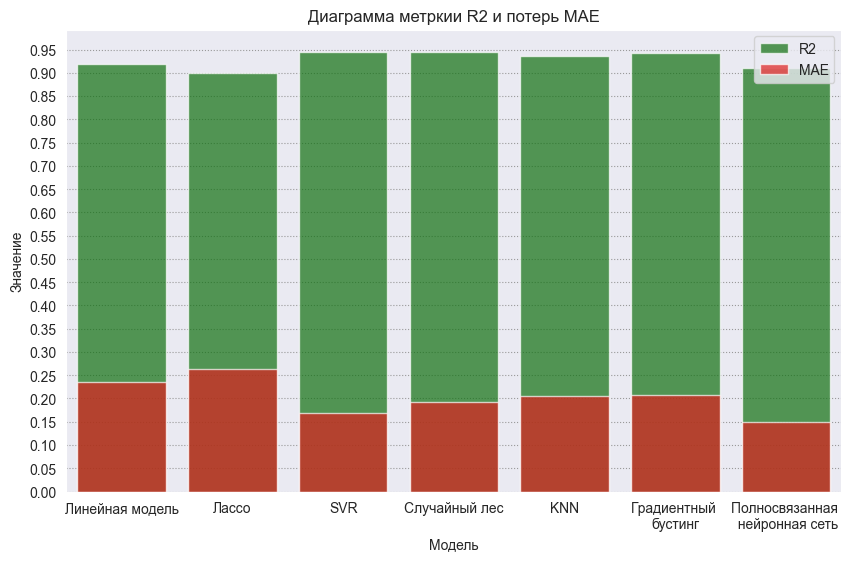

In [46]:
# Настройка размера графика
plt.figure(figsize=(10, 6))

# Настройка стиля графика
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# Создание графика для метрики R2
ax = sns.barplot(x='Модель', y='R2', data=metrics_df, color='green', alpha=0.7, label='R2')

# Создание графика для метрики MAE поверх графика R2
sns.barplot(x='Модель', y='MAE', data=metrics_df, color='red', alpha=0.7, label='MAE', ax = ax)

# Настройка шкалы оси y
plt.yticks(np.arange(0, 1, 0.05))  

# Подписи осей
plt.xlabel('Модель')
plt.ylabel('Значение')

# Заголовок графика
plt.title('Диаграмма метрики R2 и потерь MAE')

# Легенда графика
plt.legend() 

# Отображение графика
plt.show() 

# Сохранение графика в файл
fig = ax.get_figure()
fig.savefig('Диаграмма метрики R2 и потерь MAE')

## Выводы по диаграмме метрик R2 и потерь MAE

- **SVR (Support Vector Regression)**: Эта модель демонстрирует наивысший коэффициент детерминации `R^2` и наименьшее значение средней абсолютной ошибки (MAE). Это указывает на то, что SVR является наиболее эффективной моделью для предсказания исходов в данном наборе данных.

- **Случайный лес, KNN (K-ближайших соседей) и Градиентный бустинг**: Эти модели показывают сильные результаты как по `R^2`, так и по MAE. Все они имеют хорошие показатели и могут быть рассмотрены как надежные варианты для задачи прогнозирования.

- **Линейная модель и Лассо**: Обе модели имеют более низкие значения `R^2` и более высокие значения MAE по сравнению с другими рассмотренными моделями. Это может свидетельствовать о том, что они менее способны улавливать сложности в данных и могут не быть оптимальным выбором для данной задачи.

- **Полносвязанная нейронная сеть**: Несмотря на то что эта модель не имеет самого высокого `R^2`, она показывает наименьший MAE, что указывает на ее потенциал в точности предсказаний.

В целом, модели с более высоким `R^2` и низким MAE предпочтительны, так как они обеспечивают лучшую объясняющую способность и точность предсказаний, но в веб-интерфейсе будет возможность использования всех обученных моделей